In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Change the sampling rate and specify the data after stimulation.

In [2]:
gauge_md_index = np.array([ 265,  520,  789, 1043, 1312, 1567])
frac_hit_index = np.array([589, 830])

In [3]:
# New version: 
extend_nx = 2000

nx_old = 1600
nt = 500

dx = 1
dt = 60

In [4]:
x = np.arange(0, nx_old) * dx
t = np.arange(0, nt) * dt

# extend x by add negative value and positive value
x = np.concatenate([x - extend_nx * dx, x, x + extend_nx * dx])
nx = len(x)

In [5]:
# update gauge_md_index
gauge_md_index = gauge_md_index + extend_nx
frac_hit_index = frac_hit_index + extend_nx

In [6]:
# store the solution
u = np.zeros((nt, nx))

In [7]:
# Time 
stg1_start = 30
stg1_end = 250

stg2_start = 400

In [8]:
# diffusivity initialization
initial_diffusivity = 90 * dt
decay_factor = 0.05 # should be less than 1
d = np.ones(nx) * initial_diffusivity # ft^2/s

inj_pressure = [500, 300]

In [9]:
# stg 1: 100; stg 2: 500. Do const pressure while during simulation.

# phase 1: before stimulation 
from tqdm import tqdm
for iter in tqdm(range(stg1_start, stg1_end)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    np.fill_diagonal(A, 1 + 2 * alpha)
    np.fill_diagonal(A[1:], -alpha)
    np.fill_diagonal(A[:, 1:], -alpha)

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # Source term, only one cell
    A[frac_hit_index[0], :] = 0
    A[frac_hit_index[0], frac_hit_index[0]] = 1
    b[frac_hit_index[0]] = inj_pressure[0]
    # A[frac_hit_index[0], :] = 0
    # A[frac_hit_index[0], frac_hit_index[0]] = 1
    # b[frac_hit_index[0]] = 500
    
    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [01:51<00:00,  1.98it/s]


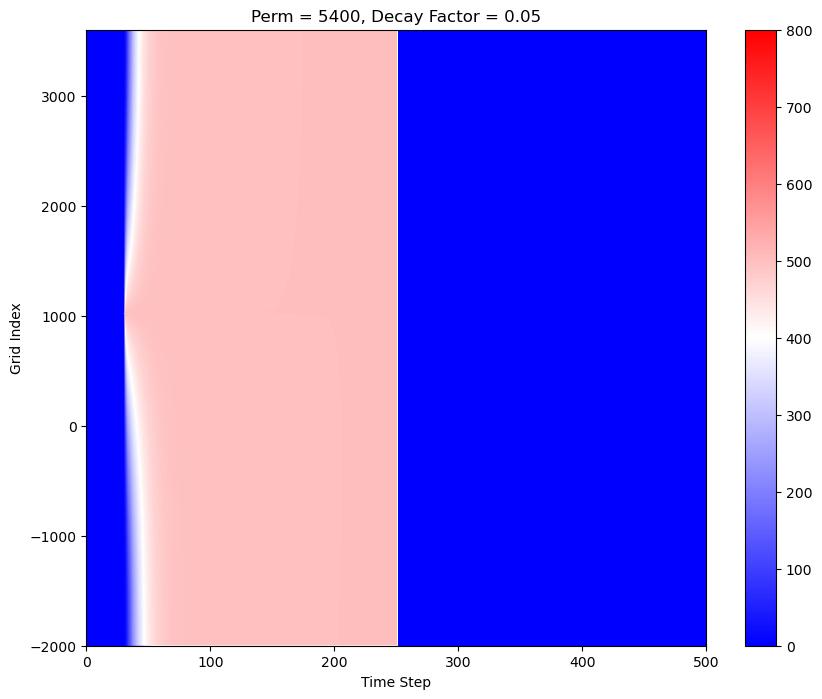

In [10]:
# Plot the solution
# QC. Show the final result
plt.figure(figsize=(10, 8))
plt.imshow(u.T, aspect='auto', cmap='bwr', extent=[0, nt, x[-1], x[0]])
# Set x and y label
plt.xlabel("Time Step")
plt.ylabel("Grid Index")
plt.clim(0, 800)
# invert the y axis
plt.gca().invert_yaxis()

plt.title(f"Perm = {initial_diffusivity}, Decay Factor = {decay_factor}")
plt.colorbar()
plt.show()

In [11]:
# phase 2: after stimulation. Before stage 2

# FD simulation
for iter in tqdm(range(stg1_end, stg2_start)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # No source term in this phase

    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)
    # update the diffusivity at the injection point
    d[frac_hit_index[0]] = d[frac_hit_index[0]] * (1 - decay_factor)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:16<00:00,  1.95it/s]


In [12]:
# Phase 3: stage 2 stimulation
# update the diffusivity coefficient in stage 1
for iter in tqdm(range(stg2_start, nt-1)):
    # determine the injection pressure: 
    A = np.zeros((nx, nx))
    b = np.zeros(nx)

    alpha = d * dt / dx**2
    # Fill the matrix A and b
    # Diag: 
    # np.fill_diagonal(A, 1 + 2 * alpha)
    # np.fill_diagonal(A[1:], -alpha)
    # np.fill_diagonal(A[:, 1:], -alpha)

    for i in range(1, nx-1):
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i-1] = -alpha[i]
        A[i, i+1] = -alpha[i]

    # Boundary condition, Neumann boundary condition
    A[0, 0] = 1
    A[0, 1] = -1

    A[-1, -1] = 1
    A[-1, -2] = -1

    # fill b
    b = u[iter]
    # boundary condition
    b[0] = 0
    b[-1] = 0

    # Source term, only one cell
    A[frac_hit_index[1], :] = 0
    A[frac_hit_index[1], frac_hit_index[1]] = 1
    b[frac_hit_index[1]] = inj_pressure[1]
    
    # solve the linear system
    u[iter+1] = np.linalg.solve(A, b)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:50<00:00,  1.95it/s]


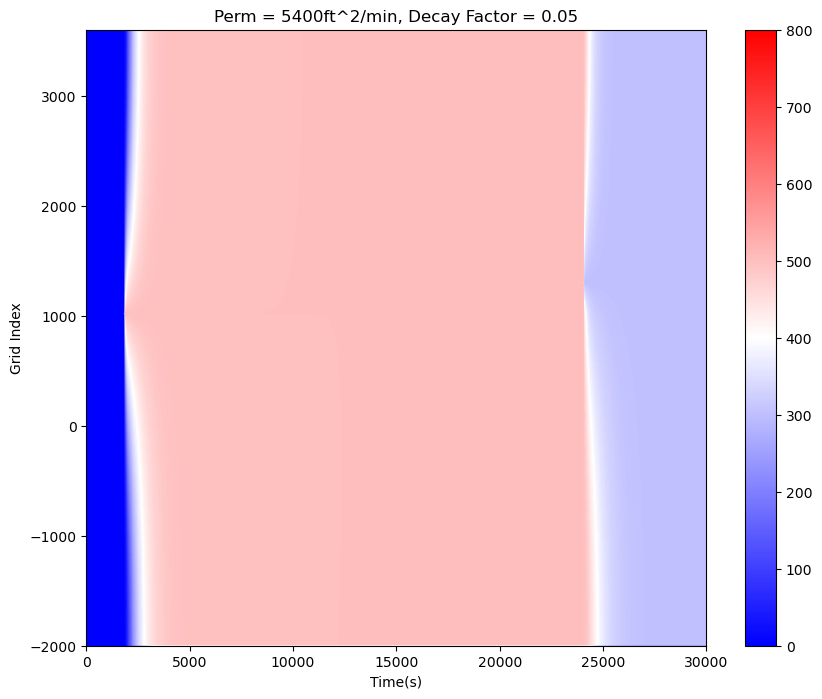

In [13]:
# Plot the solution
# QC. Show the final result
plt.figure(figsize=(10, 8))
plt.imshow(u.T, aspect='auto', cmap='bwr', extent=[0, nt * dt, x[-1], x[0]])
# Set x and y label
plt.xlabel("Time(s)")
plt.ylabel("Grid Index")
plt.clim(0, 800)
# invert the y axis
plt.gca().invert_yaxis()

plt.title(f"Perm = {initial_diffusivity}ft^2/min, Decay Factor = {decay_factor}")
plt.colorbar()
plt.show()

Text(0.5, 0, 'Time(s)')

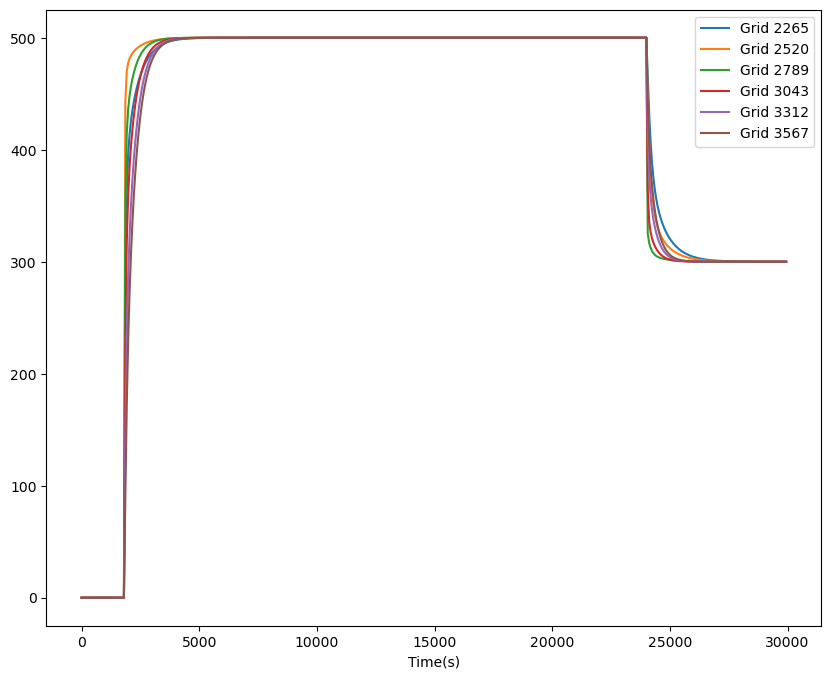

In [15]:
# plot the pressure at the gauge points
plt.figure(figsize=(10, 8))
for gauge in gauge_md_index:
    plt.plot(t, u[:, gauge], label=f"Grid {gauge}")
plt.legend()
plt.xlabel("Time(s)")